# Data preparation and transformation exercise

## Part V - Aggregate features, encode categories, scaling, reduction and decomposition

The objective of this exercise is to practice various steps of data preprocessing and feature engineering.

The scenario is the preparation of data for a ML multilinear regressions.

The dataset used is the "Climate Weather Surface of Brazil - Hourly", wich is available at <a href="https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region?select=make_dataset.py">Kaggle</a>.

It contains hourly climate data taken from 122 weather stations in Brasil between 2000 and 2021.

**Steps:**

1. Load data
2. Inspect data
3. Format features
4. Clean messy data
5. Remove duplicate values
6. Treat missing values
7. Imputation
8. Remove strongly correlated features
9. Remove outliers
10. <a href="#Aggregate-features">Aggregate features</a>
11. <a href="#Encode-categorical-features">Encode categorical features</a>
12. <a href="#Feature-scaling">Feature scaling</a>
13. <a href="#Dimensionality-reduction-and-feature-decomposition">Dimensionality reduction and feature decomposition</a>
14. Sample and balance

## Aggregate features

Brazil has six climatic regions:
- equatorial
- tropical
- semi-arid
- tropical highland
- temperate
- subtropical

![Climatic regions of Brazil](./images/mapa-climas-brasil.jpeg "Climatic regions of Brazil")
From https://brasilescola.uol.com.br/brasil/os-climas-brasil.htm

We can use the latitude and longitude to assign each station a categorical feature 'climate' using the [eeWeather API](https://eeweather.readthedocs.io/en/latest/api.html#).


Let's recover the stations' latitudes and longitudes from the original dataset

In [54]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
dataset = pickle.load(open("newindex_dataset.pkl", "rb"))

In [55]:
dataset.drop(columns = ['full_time', 'precipitation', 'pressure', 'pressure_max',
                        'pressure_min', 'solar_radiation', 'air_temperature', 'dp_temperature',
                        'air_temp_max', 'air_temp_min', 'dp_temp_max', 'dp_temp_min',
                        'rel_hum_max', 'rel_hum_min', 'Rel_humidity', 'wind_direction',
                        'wind_gust', 'wind_speed', 'region', 'state',
                        'station_id', 'Elevation', 'year'], inplace = True)

In [56]:
dataset.drop_duplicates(inplace=True)

In [57]:
dataset

,station_name,Latitude,Longitude
0,PARANOA (COOPA-DF),-16.011111,-47.557500
274,BELA VISTA,-22.100833,-56.540000
9034,NOVA UBIRATA,-13.686389,-54.956111
11013,GOIANIA,-16.642778,-49.220000
18881,CARLINDA,-10.005278,-55.790556
...,...,...,...
3470857,ARAGARCAS,-15.902778,-52.245278
3565897,SILVANIA,-16.679722,-48.618056
3678217,TRES LAGOAS,-20.783333,-51.712222
3721417,PORANGATU,-13.309444,-49.117500


We only have 115 weather stations. As we saw earlier, there is one name correction and multiple latitude/longitude updates.

In [58]:
dataset.replace ("BRASNORTE (MUNDO NOVO)", "BRASNORTE (NOVO MUNDO)" , inplace = True)

In [59]:
dataset.loc[dataset.station_name == "BRASNORTE (NOVO MUNDO)"]

,station_name,Latitude,Longitude
149815,BRASNORTE (NOVO MUNDO),-12.871944,-58.387222
2282707,BRASNORTE (NOVO MUNDO),-12.521944,-58.231389


When the station name was updated the coordinates were updated too.

Next we'll eliminate the latutude/longitude variants for the stations, keeping only the most recent value.

In [60]:
# order by index descending, to get the most recent value first
dataset.sort_index(axis=0, ascending=False, inplace=True)

In [61]:
# drop older values of latitude/longitude
dataset.drop_duplicates(subset=['station_name'], inplace=True)
dataset

,station_name,Latitude,Longitude
3753097,CARLINDA,-9.970556,-55.827500
3721417,PORANGATU,-13.309444,-49.117500
3678217,TRES LAGOAS,-20.783333,-51.712222
3565897,SILVANIA,-16.679722,-48.618056
3470857,ARAGARCAS,-15.902778,-52.245278
...,...,...,...
350336,AMAMBAI,-23.002500,-55.329444
294050,SETE QUEDAS,-23.966944,-55.024167
279903,PRIMAVERA DO LESTE,-15.580000,-54.381111
182334,SANTO ANTONIO DO LESTE,-14.927778,-53.883611


Now we'll create a new feature (climate) using the eeWeather API.

In [62]:
import eeweather
# eeweather-0.3.24

In [63]:
# example: print data for station in USA
latitude=35.283
longitude=-95.1
dict_of_str = eeweather.get_lat_long_climate_zones(latitude, longitude)
print(dict_of_str["ba_climate_zone"])

Mixed-Humid


In [64]:
for i in dataset.station_name:
    latitude = float(dataset.loc[dataset.station_name == i, 'Latitude'])
    longitude = float(dataset.loc[dataset.station_name == i, 'Longitude'])
    dict_of_str = eeweather.get_lat_long_climate_zones(latitude, longitude);
    print("The station {} has climate type: {}".format(i, dict_of_str["ba_climate_zone"]))

The station CARLINDA has climate type: None
The station PORANGATU has climate type: None
The station TRES LAGOAS has climate type: None
The station SILVANIA has climate type: None
The station ARAGARCAS has climate type: None
The station SINOP has climate type: None
The station SAPEZAL has climate type: None
The station SAO MIGUEL DO ARAGUAIA has climate type: None
The station ITAPACI has climate type: None
The station IVINHEMA has climate type: None
The station ALTO PARAISO DE GOIAS has climate type: None
The station NHUMIRIM has climate type: None
The station CHAPADAO DO SUL has climate type: None
The station IPORA has climate type: None
The station ALTA FLORESTA has climate type: None
The station S.J. DO RIO CLARO has climate type: None
The station VILA BELA DA SANTISSIMA TRINDADE has climate type: None
The station RONDONOPOLIS has climate type: None
The station CAIAPONIA has climate type: None
The station BELA VISTA has climate type: None
The station TANGARA DA SERRA has climate typ

This API's database does not have the weather stations in Brazil, but the implementation is valid as a demonstration.

To proceed with the exercise, we'll randomly asign one of the six brazilian climate types to the stations.

In [65]:
climates = ['equatorial', 'tropical', 'semi-arid', 'tropical highland', 'temperate', 'subtropical']

In [66]:
# define a list of 115 randomly picked climates
s_climates = [climates[i] for i in np.random.randint(5, size=(115))]

# add the list of climates as a new column
dataset.insert (loc = 3, column="climate", value =s_climates )

In [67]:
# we can drop the coordinates and use the station names as index
dataset.set_index('station_name', inplace=True)
dataset.drop(columns = ['Latitude', 'Longitude'], inplace=True)

In [68]:
dataset

,climate
station_name,
CARLINDA,equatorial
PORANGATU,tropical
TRES LAGOAS,equatorial
SILVANIA,semi-arid
ARAGARCAS,equatorial
...,...
AMAMBAI,tropical
SETE QUEDAS,equatorial
PRIMAVERA DO LESTE,semi-arid


In [69]:
pickle.dump(dataset, open("station_climates.pkl", "wb"))

We have the climate type of each station. Now we need to add this information to the data.

In [70]:
station_climate = dataset

In [104]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
dataset = pickle.load(open("no_outliers_dataset.pkl", "rb"))

In [105]:
stations = dataset.station_name
stations

0          PARANOA (COOPA-DF)
1          PARANOA (COOPA-DF)
2          PARANOA (COOPA-DF)
3          PARANOA (COOPA-DF)
4          PARANOA (COOPA-DF)
                  ...        
3738692    SERRA NOVA DOURADA
3738693    SERRA NOVA DOURADA
3738694    SERRA NOVA DOURADA
3738695    SERRA NOVA DOURADA
3738696    SERRA NOVA DOURADA
Name: station_name, Length: 9368820, dtype: object

In [106]:
station_climate

,climate
station_name,
CARLINDA,equatorial
PORANGATU,tropical
TRES LAGOAS,equatorial
SILVANIA,semi-arid
ARAGARCAS,equatorial
...,...
AMAMBAI,tropical
SETE QUEDAS,equatorial
PRIMAVERA DO LESTE,semi-arid


In [107]:
dataset['climate'] = dataset.station_name.copy()

In [108]:
# there are now two columns ('station_name' and 'climate') with the name of the station
dataset.iloc[:,-2:].head()

,station_name,climate
0,PARANOA (COOPA-DF),PARANOA (COOPA-DF)
1,PARANOA (COOPA-DF),PARANOA (COOPA-DF)
2,PARANOA (COOPA-DF),PARANOA (COOPA-DF)
3,PARANOA (COOPA-DF),PARANOA (COOPA-DF)
4,PARANOA (COOPA-DF),PARANOA (COOPA-DF)


In [109]:
# replace name of the weather station in column 'climate' with the corresponding climate type
dataset.climate = dataset.climate.apply(lambda station: station_climate.loc[station])

In [112]:
# now the column 'climate' has the correct value
dataset.iloc[:,-2:].head()

,station_name,climate
0,PARANOA (COOPA-DF),semi-arid
1,PARANOA (COOPA-DF),semi-arid
2,PARANOA (COOPA-DF),semi-arid
3,PARANOA (COOPA-DF),semi-arid
4,PARANOA (COOPA-DF),semi-arid


In [111]:
pickle.dump(dataset, open("aggregated_dataset.pkl", "wb"))

## Encode categorical features

In [79]:
from sklearn.preprocessing import OneHotEncoder

Considering the scenario where the data will be used to do multivariate regression per station, the station_name does not need to be encoded and we will only need to one-hot enconde the new feature we aggregated (climate).

In [80]:
enc = OneHotEncoder(handle_unknown='ignore')
encoded_climate = pd.DataFrame(enc.fit_transform(dataset[['climate']]).toarray())
dataset = dataset.join(encoded_climate)

In [81]:
# we nolonger need this feature
dataset.drop(columns = "climate", inplace=True)

In [82]:
dataset

,full_time,precipitation,pressure,pressure_max,pressure_min,solar_radiation,air_temperature,dp_temperature,air_temp_max,air_temp_min,...,dp_temp_min,wind_direction,wind_gust,wind_speed,station_name,0,1,2,3,4
0,2017-12-20 14:00:00,0.0,899.6,900.0,899.6,3391.000000,26.5,17.70000,26.5,24.4,...,16.500000,39.0,9.6,3.9,PARANOA (COOPA-DF),0.0,1.0,0.0,0.0,0.0
1,2017-12-20 15:00:00,0.0,899.2,899.6,899.2,3306.000000,26.6,16.70000,26.7,25.4,...,16.000000,55.0,8.3,3.4,PARANOA (COOPA-DF),0.0,1.0,0.0,0.0,0.0
2,2017-12-20 16:00:00,0.0,898.6,899.2,898.6,3167.000000,27.3,15.80000,27.6,25.9,...,14.500000,62.0,8.3,3.6,PARANOA (COOPA-DF),0.0,1.0,0.0,0.0,0.0
3,2017-12-20 17:00:00,0.0,897.7,898.6,897.7,3279.000000,27.5,12.90000,28.5,26.6,...,12.900000,43.0,6.7,3.1,PARANOA (COOPA-DF),0.0,1.0,0.0,0.0,0.0
4,2017-12-20 18:00:00,0.0,897.0,897.7,897.0,2753.000000,27.5,13.70000,28.9,27.4,...,12.400000,98.0,6.4,3.5,PARANOA (COOPA-DF),0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738692,2021-04-30 19:00:00,0.0,960.6,960.9,960.3,1716.000000,28.4,21.24697,29.1,28.1,...,20.773438,80.0,7.6,4.7,SERRA NOVA DOURADA,0.0,1.0,0.0,0.0,0.0
3738693,2021-04-30 20:00:00,0.0,960.6,960.6,960.3,1233.000000,28.3,21.24697,28.7,28.2,...,20.773438,82.0,7.6,3.0,SERRA NOVA DOURADA,0.0,1.0,0.0,0.0,0.0
3738694,2021-04-30 21:00:00,0.0,960.9,960.9,960.6,477.000000,26.4,21.24697,28.3,26.4,...,20.773438,89.0,4.8,1.8,SERRA NOVA DOURADA,0.0,1.0,0.0,0.0,0.0
3738695,2021-04-30 22:00:00,0.0,961.4,961.4,960.9,1.000000,25.5,21.24697,26.4,25.5,...,20.773438,122.0,2.5,1.4,SERRA NOVA DOURADA,0.0,1.0,0.0,0.0,0.0


In [83]:
pickle.dump(dataset, open("encoded_dataset.pkl", "wb"))

## Feature scaling

In [84]:
from sklearn.preprocessing import MinMaxScaler

As we saw earlier, the numeric features in this dataset use different scales. For machine learning models to be able to interpret these features on the same scale we need to perform feature scaling. For this we will use Scikit-Learn.

**Warning:** In a real world application we  should not use values from the test dataset for outlier removal. However, in order to keep this exercise simple, we will ignore this and remove the outliers before spliting the dataset.

As we saw earlier, IQR is really bad for determining outliers, therefore RobustScaler is out of the question and MinMaxScaler is probably the best fit.

In [85]:
numeric_features = ["precipitation",
                    "pressure",
                    "pressure_max",
                    "pressure_min",
                    "solar_radiation",
                    "air_temperature",
                    "dp_temperature",
                    "air_temp_max",
                    "air_temp_min",
                    "dp_temp_max",
                    "dp_temp_min",
                    "wind_direction",
                    "wind_gust",
                    "wind_speed"]

In [86]:
# create scaler and scale all numeric features
min_max_scaler = MinMaxScaler()
dataset[numeric_features] = min_max_scaler.fit_transform(dataset[numeric_features])

Let's look at the histogram of one of the scaled features in one of the stations

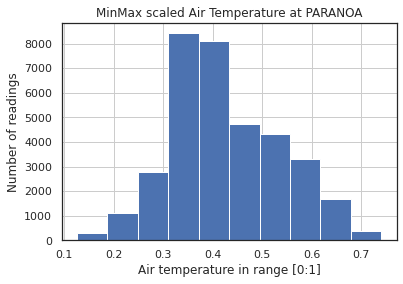

In [87]:
dataset.loc[dataset.station_name == 'PARANOA (COOPA-DF)'].air_temperature.hist(bins=10)
plt.xlabel('Air temperature in range [0:1]')
plt.ylabel('Number of readings')
plt.title('MinMax scaled Air Temperature at PARANOA');

We can see that the feature values now fall in the range from zero to one.

In [88]:
pickle.dump(min_max_scaler, open("min_max_scaler.pkl", "wb"))
pickle.dump(dataset, open("scaled_dataset.pkl", "wb"))

## Dimensionality reduction and feature decomposition

The objetive of Feature Decomposition is to decompose the original dataset into several subsets, which allows us to break down a complex problem into
several manageable problems. This is crucial in order to avoid the combinatorial explosion that can easily happen in Machine Learning.

Alternative approaches proposed for this dataset:
- Split the dataset per station, keeping all features (this was done above in varous parts of this notebook)
- Remove maximum and minimum features, as they are contained in the day's hourly measurements anyway (simple column drop)
- Keep only data from the past year, or couple of years